<h1>Yield Curves interpolations</h1>

Let's take a specific YC (US and Japan. The goal is get the risk free rate for any point in time)

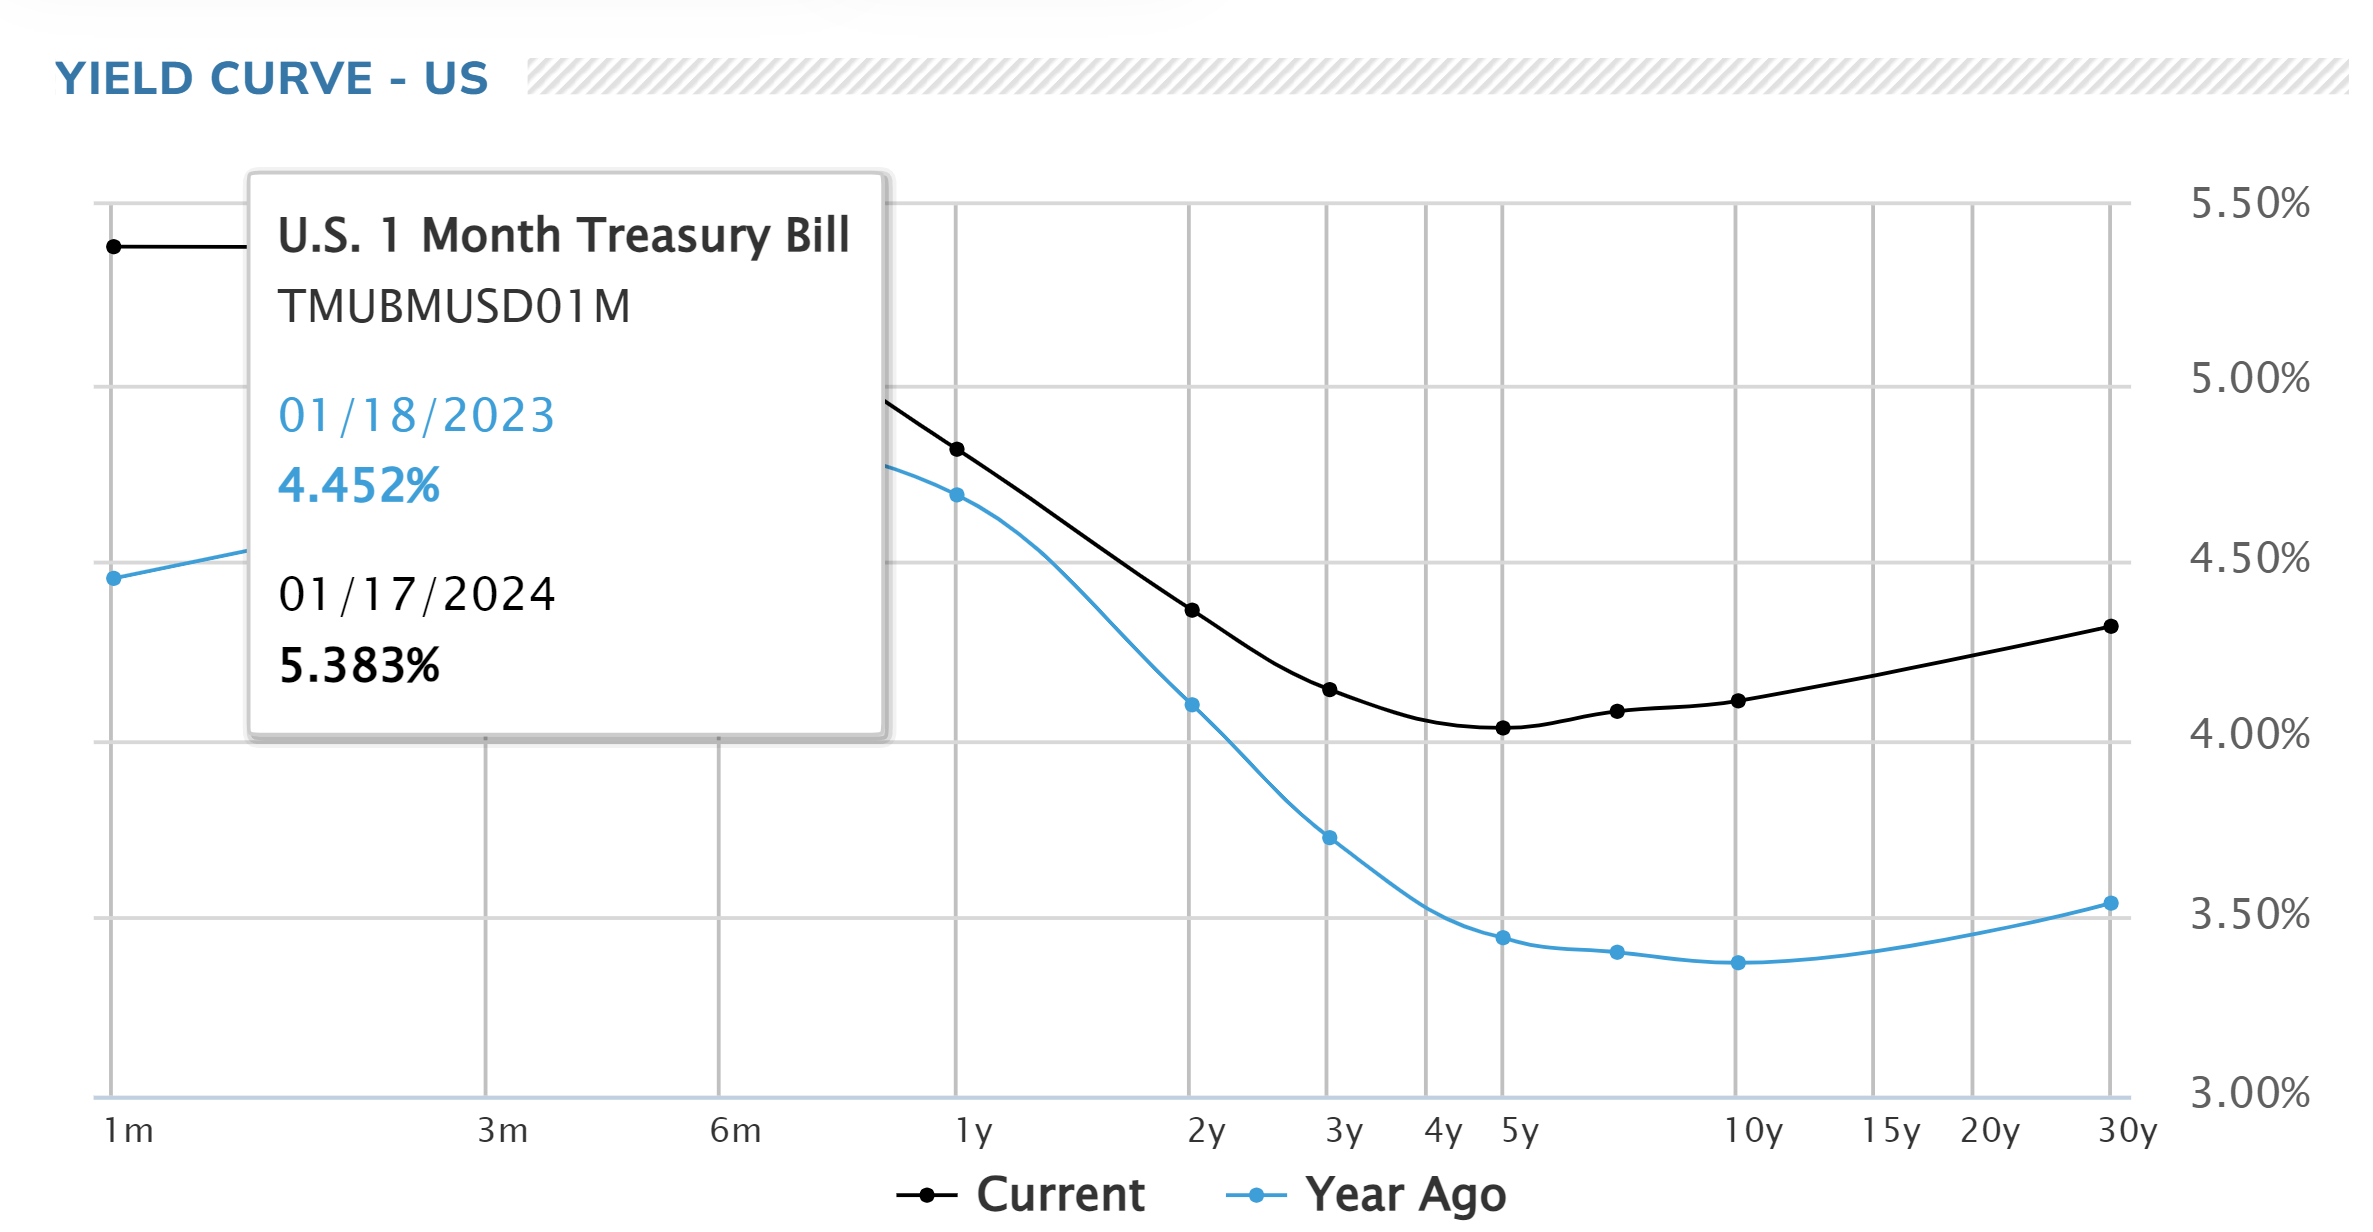

On the 17th of Jan 2024, this is the chart plotted by Market Watch.

The goal of this Jupyter notebook is to reproduce this chart using only the marker data points, and interpolation to get a continuous yield curve.

The JPY YC is below:
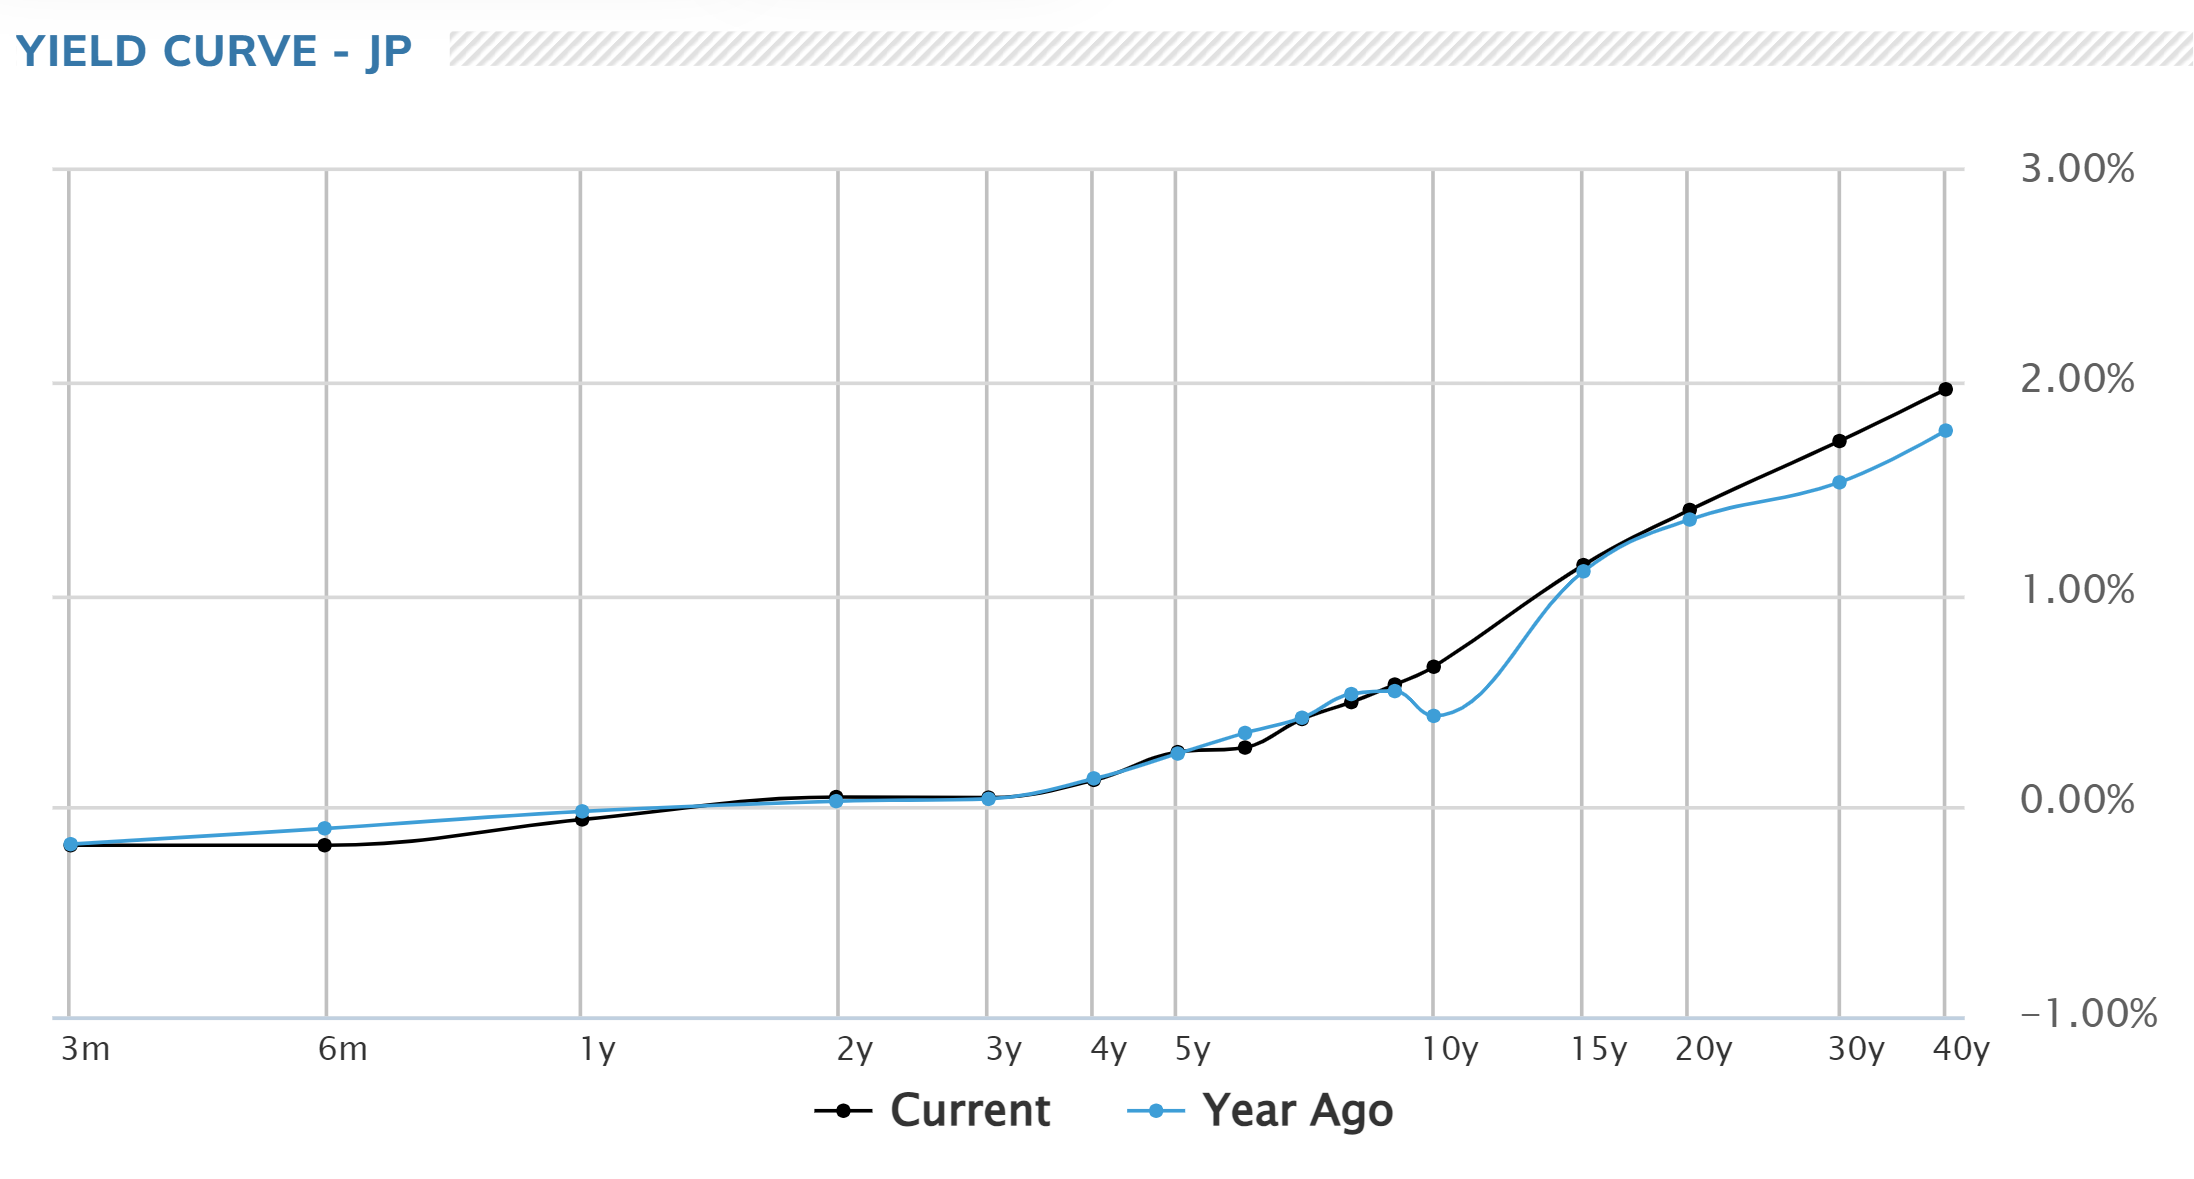

Lets input the data:

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# datasets:

us_yc = {
    "1m": 0.05383,
    "3m": 0.05381,
    "6m": 0.05213,
    "1y": 0.04815,
    "2y": 0.04363,
    "3y": 0.04140,
    "5y": 0.04032,
    "10y": 0.04109,
    "30y": 0.04318,
}

jp_yc = {
    "3m": -0.00190,
    "6m": -0.00190,
    "1y": -0.00068,
    "2y": 0.00038,
    "3y": 0.00035,
    "4y": 0.00119,
    "5y": 0.00251,
    "10y": 0.00655,
    "15y": 0.01136,
    "30y": 0.01968,
}

def create_dataframe_from_dict(data_dict):
    try:
        data_dict["0.083y"] = data_dict.pop("1m")
    except:
        pass
    try:
        data_dict["0.167y"] = data_dict.pop("2m")
    except:
        pass
    try:
        data_dict["0.25y"] = data_dict.pop("3m")
    except:
        pass
    try:
        data_dict["0.5y"] = data_dict.pop("6m")
    except:
        pass
        
    today = datetime.today()
    expiry_dates = [today + timedelta(days=int(float(expiry[:-1]) * 365)) for expiry in data_dict.keys()]
    df = pd.DataFrame(list(data_dict.values()), index=expiry_dates, columns=['yc_rate'])
    df.index = df.index.normalize()
    return df.sort_index()


def interpolate_df(df, method="cubic"):
    df = df.reindex(pd.date_range(start=df.index.min(),
                         end=df.index.max(),
                         freq='1D')).interpolate(method=method)
    return df


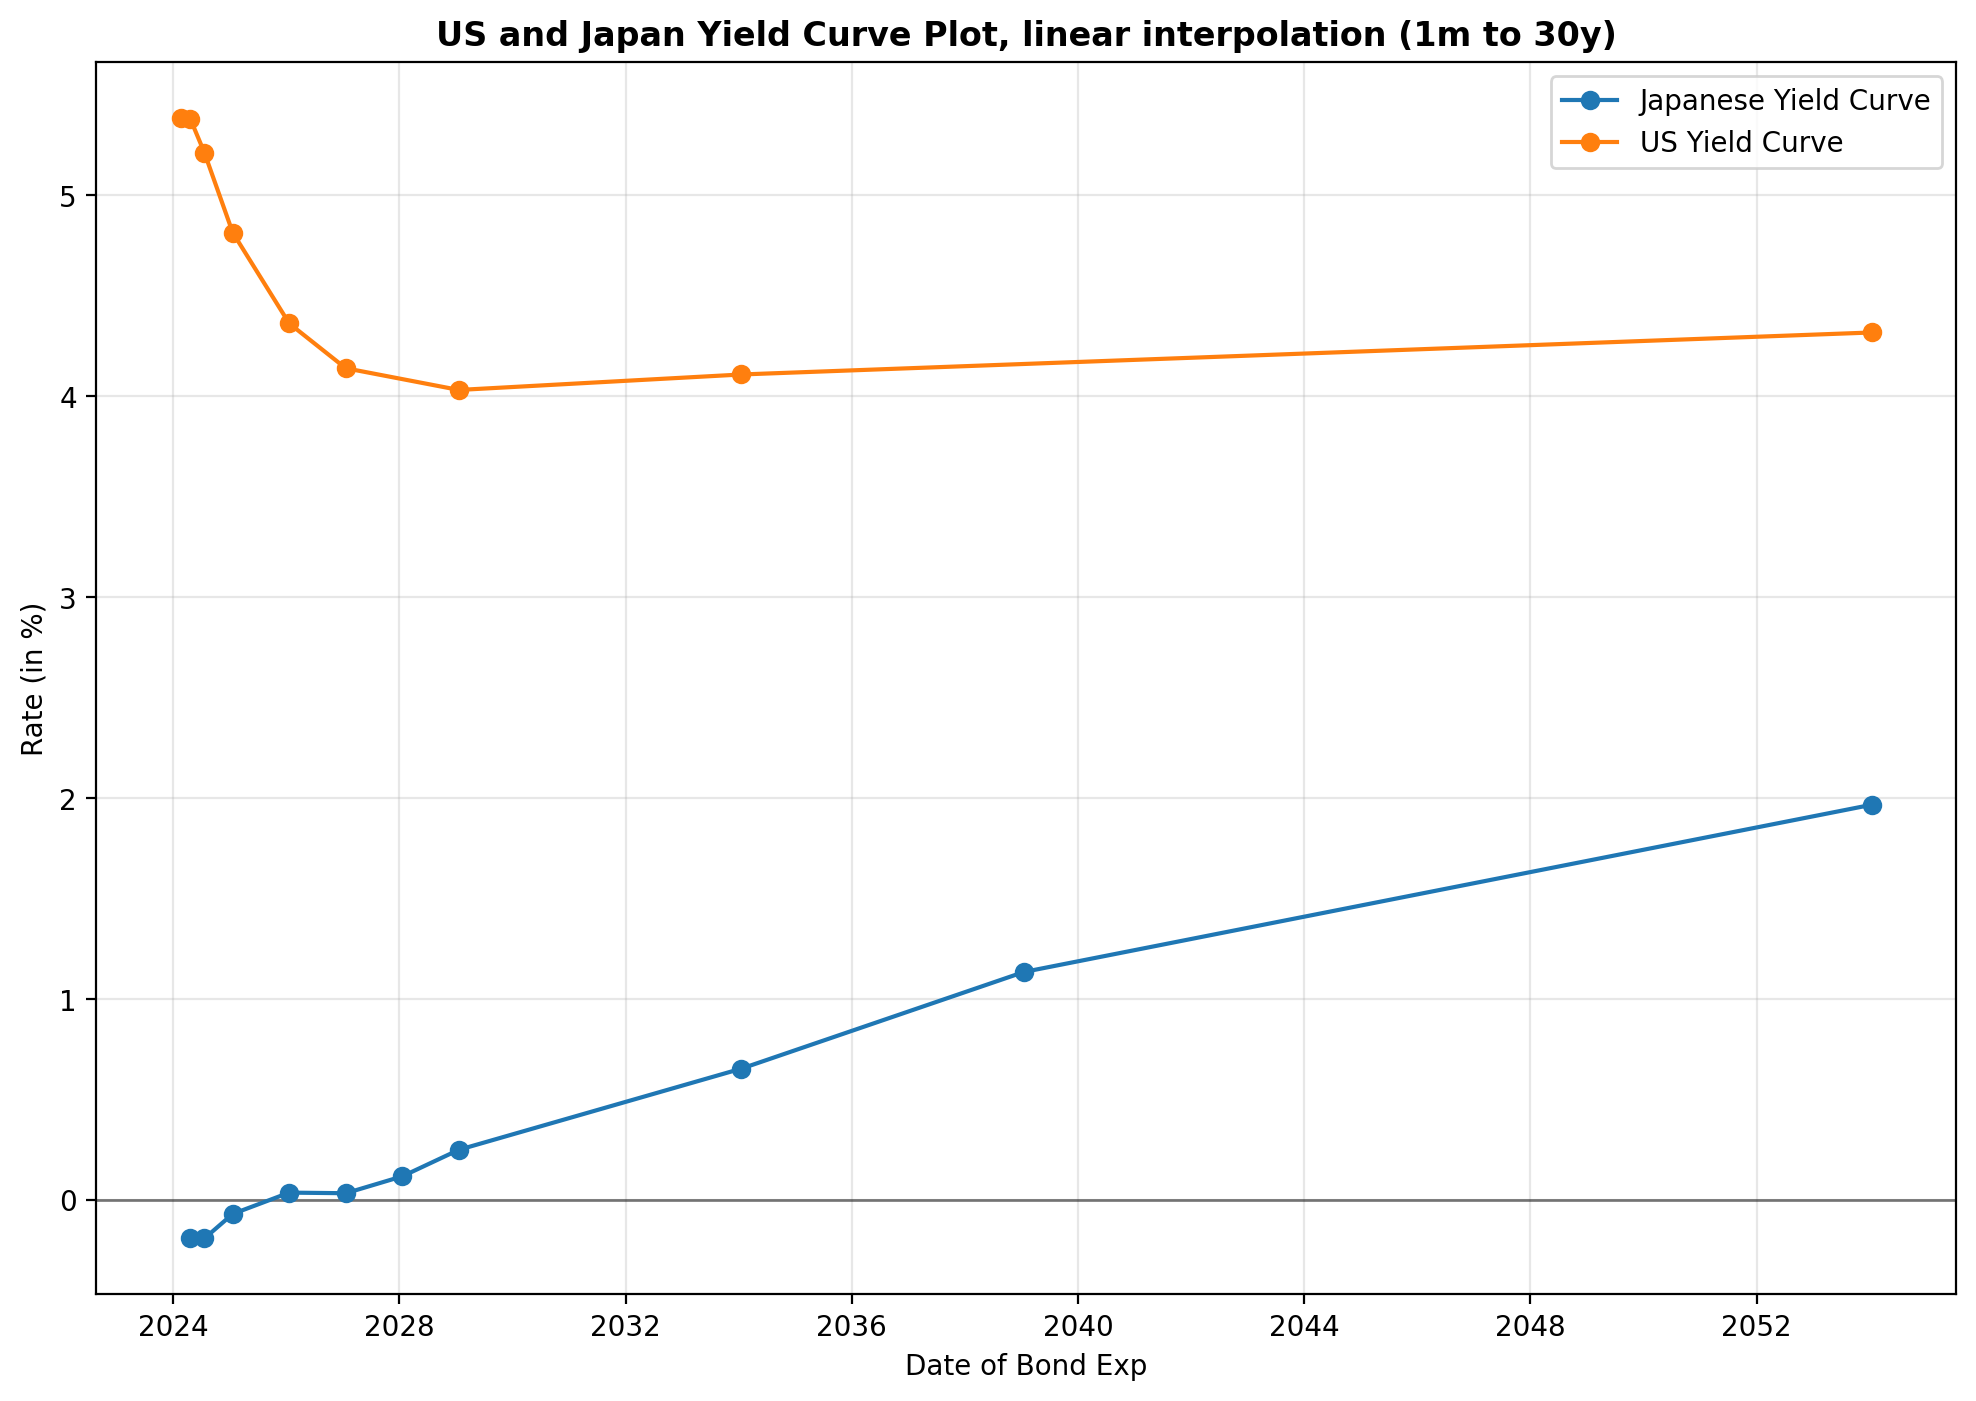

In [105]:
df_jpy = create_dataframe_from_dict(jp_yc)
df_usd = create_dataframe_from_dict(us_yc)

plt.figure(figsize=(12,8), dpi=200)
plt.axhline(0, linestyle="-", linewidth=1, alpha=0.5, color="0")
plt.plot(df_jpy*100, label="Japanese Yield Curve", marker="o")
plt.plot(df_usd*100, label="US Yield Curve", marker="o")
plt.grid(alpha=0.3)
plt.ylabel("Rate (in %)")
plt.xlabel("Date of Bond Exp")
plt.legend()
plt.title("US and Japan Yield Curve Plot, linear interpolation (1m to 30y)", fontweight="bold")
plt.show()

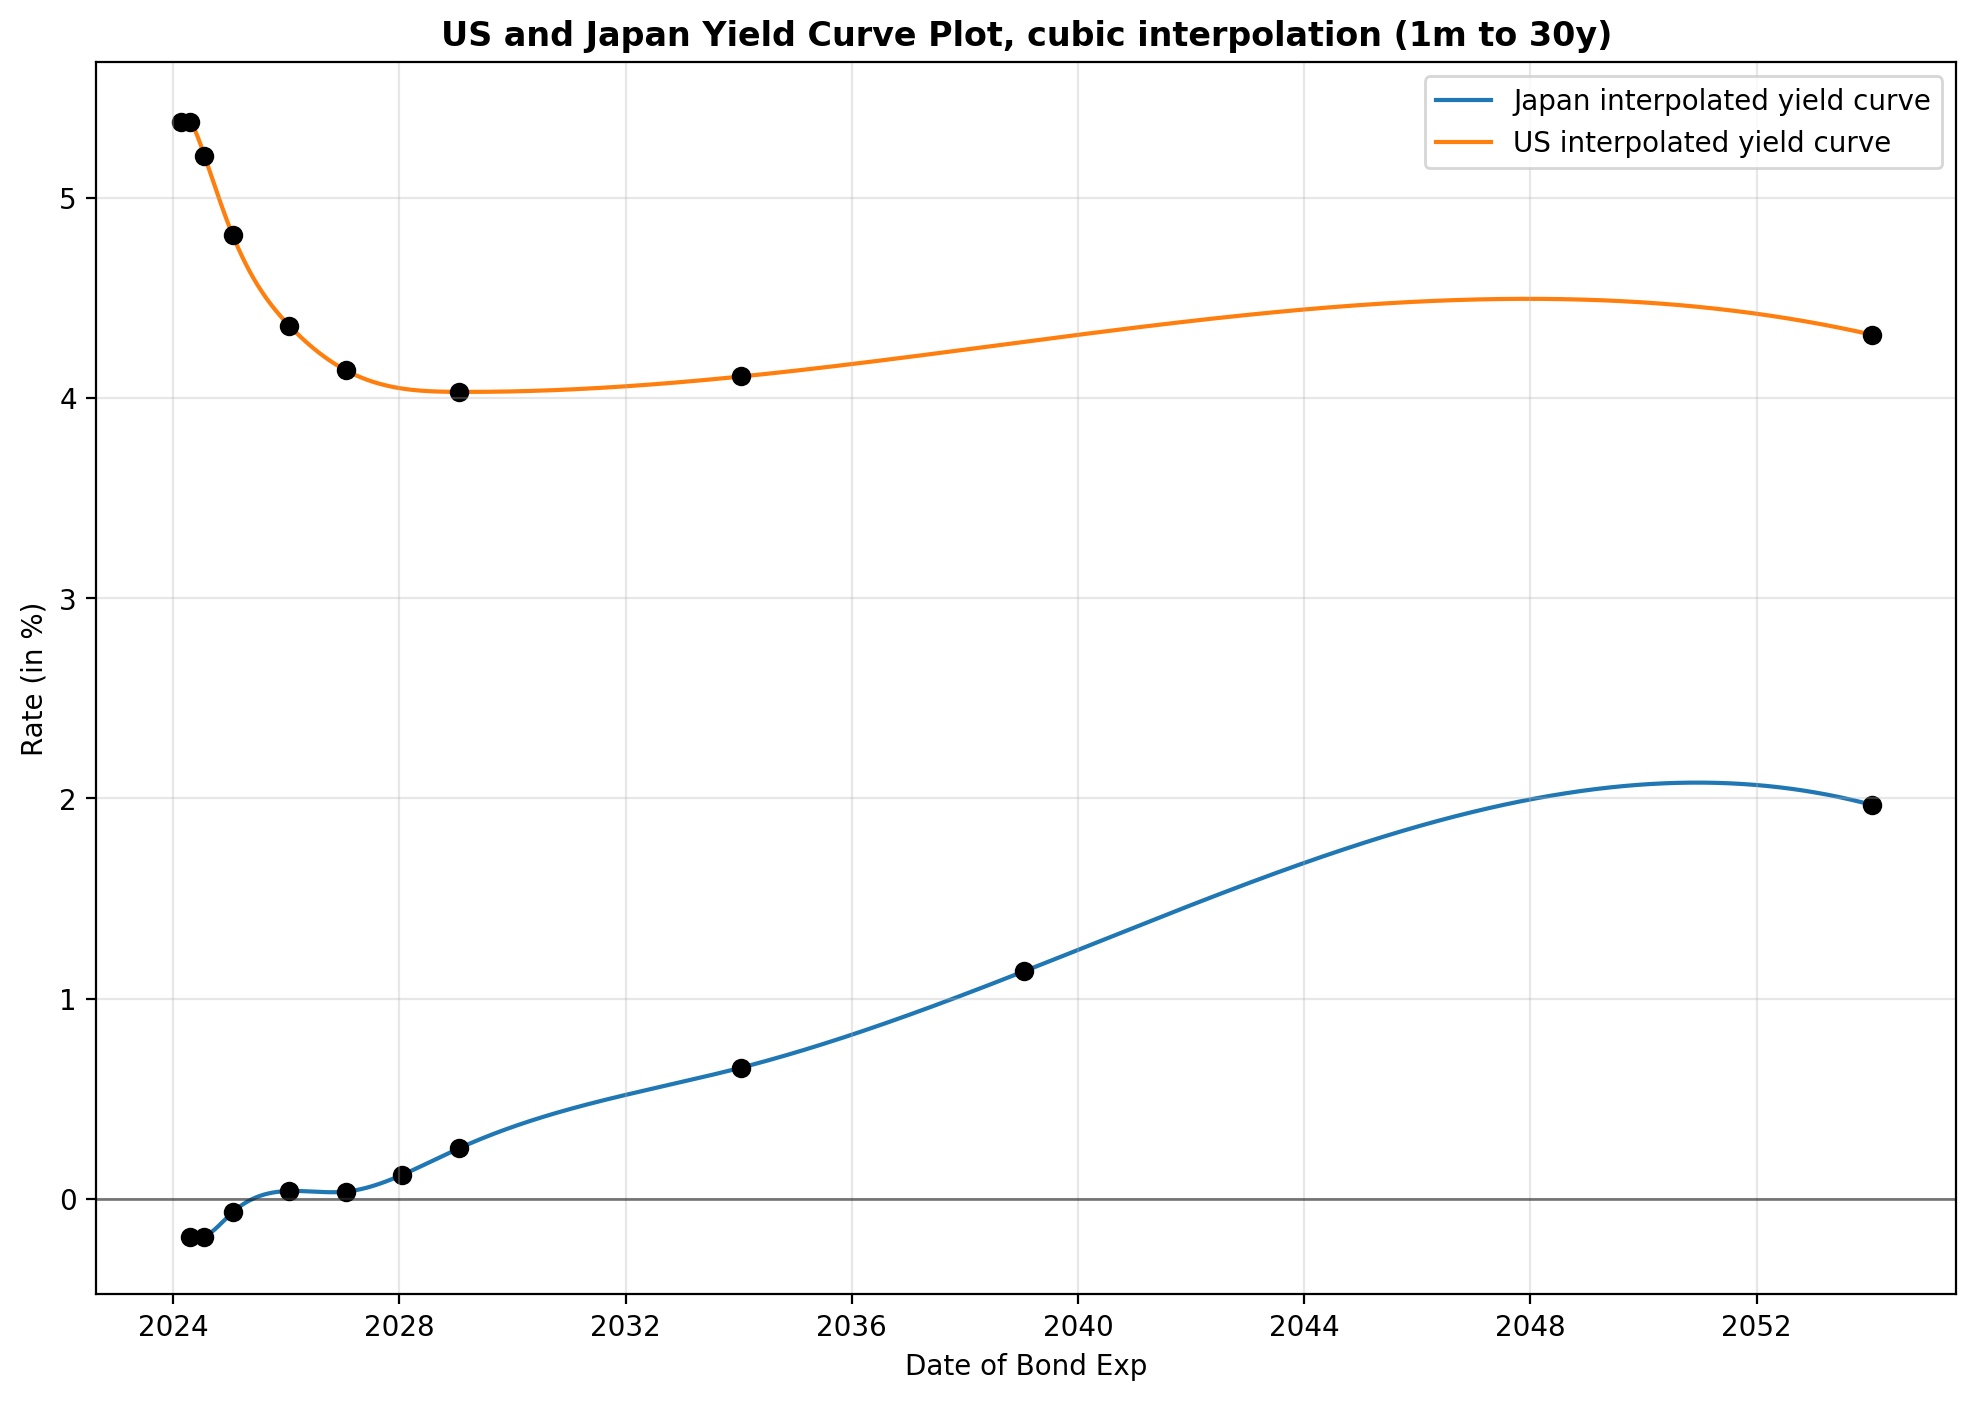

In [104]:
jpy_interp_df = interpolate_df(df_jpy, method="cubic")
us_interp_df = interpolate_df(df_usd, method="cubic")

plt.figure(figsize=(12,8), dpi=200)
plt.plot(100*jpy_interp_df, zorder=0, label="Japan interpolated yield curve")
for index, row in df_jpy.iterrows():
    plt.scatter(index, 100*row['yc_rate'], marker="o", color="0", zorder=1)
plt.plot(100*us_interp_df, zorder=0, label="US interpolated yield curve")
for index, row in df_usd.iterrows():
    plt.scatter(index, 100*row['yc_rate'], marker="o", color="0", zorder=1)
plt.grid(alpha=0.3)
plt.ylabel("Rate (in %)")
plt.xlabel("Date of Bond Exp")
plt.legend()
plt.title("US and Japan Yield Curve Plot, cubic interpolation (1m to 30y)", fontweight="bold")
plt.axhline(0, linestyle="-", linewidth=1, alpha=0.5, color="0")
plt.show()

Our interpolation gives us a risk free rate for any day until 2052. For example, lets get the yearly risk free rate (USD and JPY) for 12th of feb 2033

In [106]:
date_index = datetime(year=2033, month=2, day=12)
date_rate = jpy_interp_df.loc[date_index][0]

print(f"The Japanese risk free bond for the {date_index.day} of {date_index.strftime('%B')}, {date_index.year} is: {round(100 * date_rate, 3)}%")

The Japanese risk free bond for the 12 of February, 2033 is: 0.591%
